## Auto-encoder USPS

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from autoencoder import AutoEncoder
from activation import TanH, Sigmoid, ReLU, Softmax, LeakyReLU
from enums import GradientDescentMode
from linear import Linear
from loss import MSELoss, CELoss, BCELoss
from sequential import Sequential
from optimizers import SGD
from utils import onehot_encoding

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.manifold import TSNE

#### Parameters sharing test

In [3]:
net = AutoEncoder(
    Sequential(
        Linear(3, 4),
        TanH(),
        Linear(4, 2),
        TanH()
    ),
    Sequential(
        Linear(2, 4),
        TanH(),
        Linear(4, 3),
        Sigmoid()
    )
)   

In [4]:
print('Encoder parameters :')
print(*net.get_encoder().get_parameters(), sep='\n')
print()
print('Decoder parameters before sharing :')
print(*net.get_decoder().get_parameters(), sep='\n')
print()
print('Sharing...:')
net.parameters_sharing()
print()
print('Decoder parameters after sharing :')
print(*net.get_decoder().get_parameters(), sep='\n')

Encoder parameters :
{'W': array([[-0.44230986,  0.56003555, -0.56085414,  0.02154133],
       [-0.29153531, -0.10984333, -0.18613167,  0.58219729],
       [-0.06776526,  1.00427204,  0.07610489, -0.19756126]]), 'b': array([0., 0., 0., 0.])}
None
{'W': array([[ 0.45102845, -0.35765741],
       [-0.11112992,  0.12535445],
       [ 0.52436764, -0.63717534],
       [-0.57343321, -0.37897344]]), 'b': array([0., 0.])}
None

Decoder parameters before sharing :
{'W': array([[-1.86187681, -1.06469794,  0.61254785,  0.33490006],
       [ 0.79620779,  0.06158793,  0.89157874,  0.48630751]]), 'b': array([0., 0., 0., 0.])}
None
{'W': array([[ 0.74524229,  0.78424007,  0.06860892],
       [ 0.15318782, -0.43884549, -0.46523543],
       [-1.06652946,  0.23658884, -0.08645708],
       [ 0.63569035,  0.79115154,  0.36153322]]), 'b': array([0., 0., 0.])}
None

Sharing...:

Decoder parameters after sharing :
{'W': array([[ 0.45102845, -0.11112992,  0.52436764, -0.57343321],
       [-0.35765741,  0.12535

### USPS

In [3]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp = list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.imshow(data.reshape((16,16)), interpolation='nearest')

In [4]:
usps_train_val_x, usps_train_val_y = load_usps("data/USPS_train.txt")
usps_train_x, usps_val_x, usps_train_y, usps_val_y = train_test_split(usps_train_val_x, usps_train_val_y, test_size=.2, random_state=42)
usps_test_x, usps_test_y = load_usps("data/USPS_test.txt")
print('Train shape :', usps_train_x.shape, usps_train_y.shape)
print('Validation shape :', usps_val_x.shape, usps_val_y.shape)
print('Test shape :', usps_test_x.shape, usps_test_y.shape)

Train shape : (5832, 256) (5832,)
Validation shape : (1459, 256) (1459,)
Test shape : (2007, 256) (2007,)


In [5]:
usps_train_onehot_y = onehot_encoding(usps_train_y, 10)
usps_val_onehot_y = onehot_encoding(usps_val_y, 10)
usps_test_onehot_y = onehot_encoding(usps_test_y, 10)
print('One hot train :', usps_train_onehot_y.shape)
print('One hot val :', usps_val_onehot_y.shape)
print('One hot test :', usps_test_onehot_y.shape)

One hot train : (5832, 10)
One hot val : (1459, 10)
One hot test : (2007, 10)


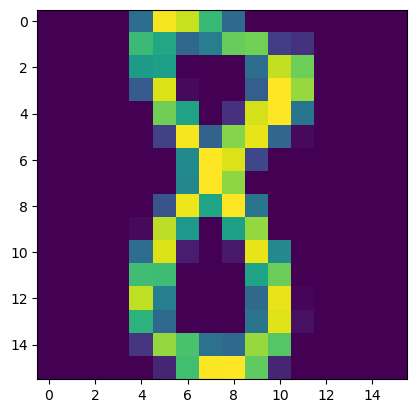

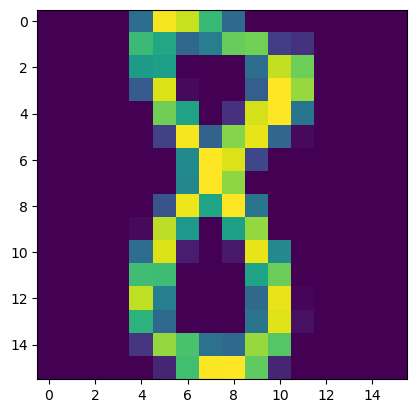

In [6]:
plt.figure()
show_usps(usps_train_x[0])
plt.figure()
show_usps(usps_train_x[0] /2)

In [7]:
usps_train_x /= 2
usps_val_x /= 2
usps_test_x /= 2

#### Linear(256,100) - TanH - Linear(100,10) - TanH & Linear - Sigmoid - Linear - Sigmoid & MSELoss

In [8]:
net = AutoEncoder(
    Sequential(
        Linear(256, 100),
        TanH(),
        Linear(100, 10),
        TanH()
    ),
    Sequential(
        Linear(10, 100),
        Sigmoid(),
        Linear(100, 256),
        Sigmoid()
    )
)   
net.parameters_sharing()

In [9]:
lr = 1e-1
epochs = 2_000
loss = MSELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    usps_train_x,
    usps_train_x,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    None,
    usps_val_x,
    usps_val_x
)

Train : -----------------------------------
Epoch 200: train loss: 0.08639126794396962 val loss: 0.08463104055333932
Epoch 400: train loss: 0.07361479357278522 val loss: 0.07227801015710761
Epoch 600: train loss: 0.06803898007346 val loss: 0.06690605947100992
Epoch 800: train loss: 0.06351693849509871 val loss: 0.06246873295835391
Epoch 1000: train loss: 0.05969156314293677 val loss: 0.058390119998364465
Epoch 1200: train loss: 0.05706091813563964 val loss: 0.056823509852727584
Epoch 1400: train loss: 0.05401336104142119 val loss: 0.05258917160989043
Epoch 1600: train loss: 0.052770853753802006 val loss: 0.051585293934154355
Epoch 1800: train loss: 0.05139578125643513 val loss: 0.05019259831787589
Epoch 2000: train loss: 0.05015855642753403 val loss: 0.049150157583235085
-------------------------------------------


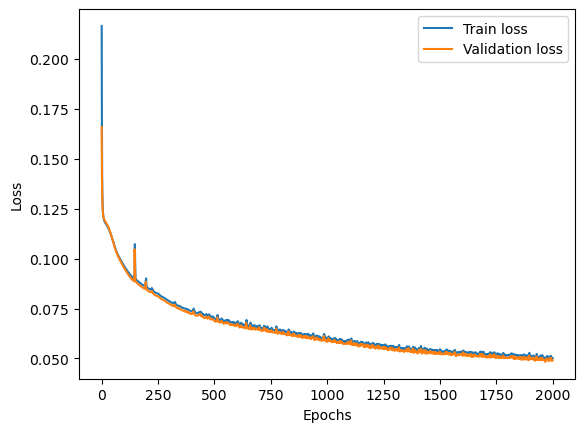

In [10]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
#net.set_parameters(best_parameters)
usps_train_autoencoder_x = net(usps_train_x)
usps_val_autoencoder_x = net(usps_val_x)
usps_test_autoencoder_x = net(usps_test_x)
usps_train_latent_x = net.get_encoder()(usps_train_x)
usps_val_latent_x = net.get_encoder()(usps_val_x)
usps_test_latent_x = net.get_encoder()(usps_test_x)

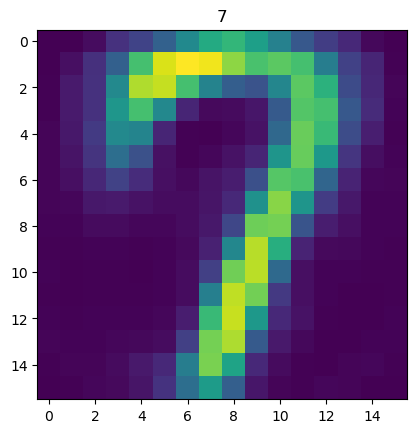

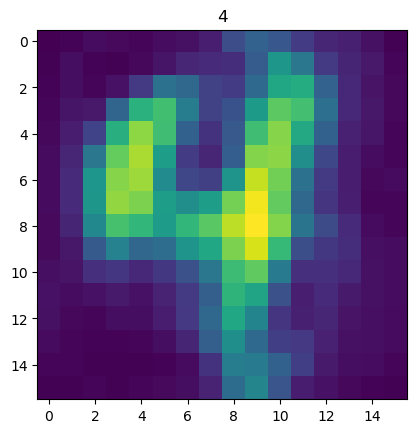

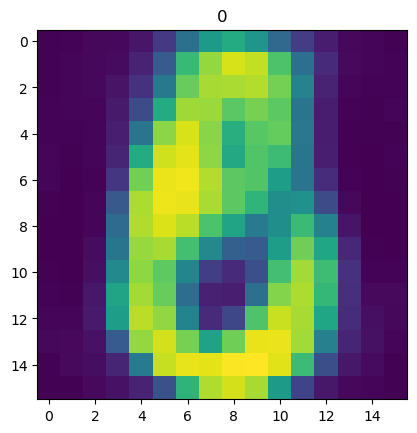

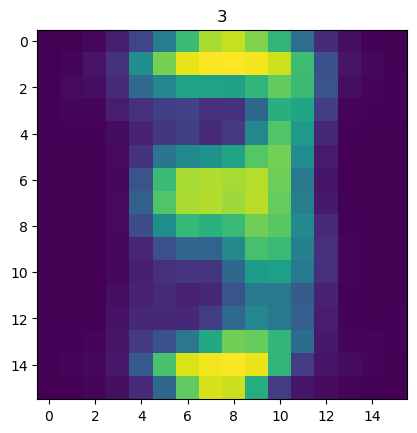

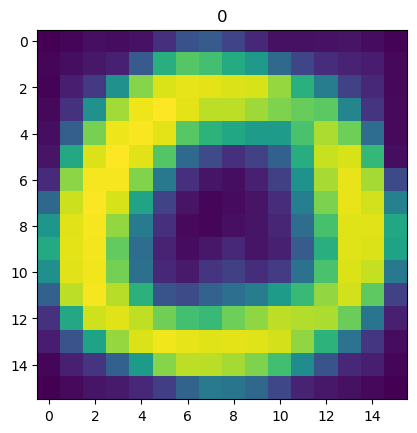

In [13]:
for i in np.random.randint(0, len(usps_train_y), 5):
    plt.figure()
    plt.title(str(usps_train_y[i]))
    show_usps(usps_train_autoencoder_x[i])
    plt.show()

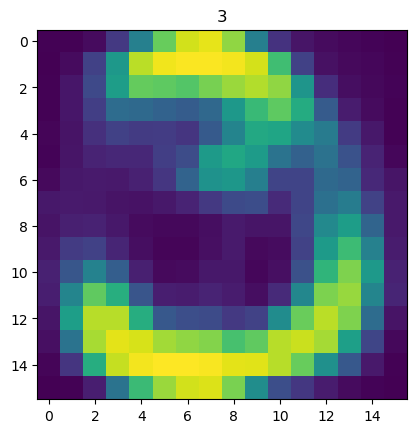

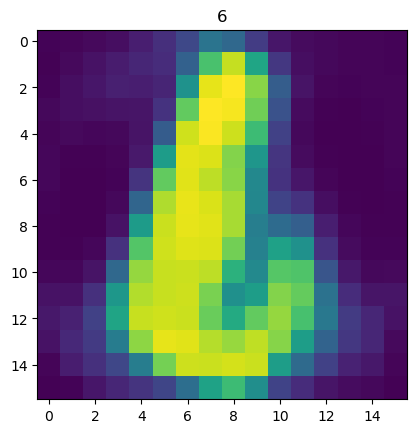

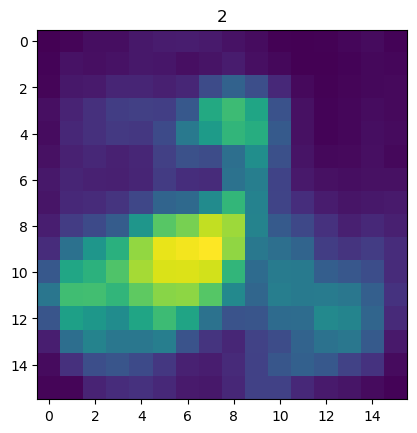

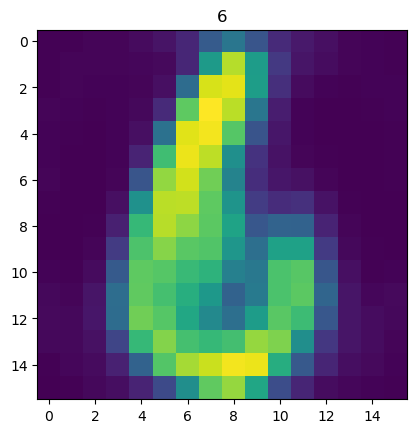

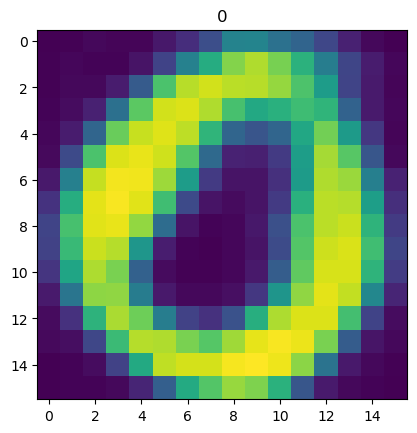

In [14]:
for i in np.random.randint(0, len(usps_test_y), 5):
    plt.figure()
    plt.title(str(usps_test_y[i]))
    show_usps(usps_test_autoencoder_x[i])
    plt.show()

In [15]:
kmeans = KMeans(n_clusters=10)
_ = kmeans.fit(usps_train_latent_x)

In [16]:
cluster_train_labels = kmeans.predict(usps_train_latent_x)
cluster_test_labels = kmeans.predict(usps_test_latent_x)

In [17]:
ari = adjusted_rand_score(usps_train_y, cluster_train_labels)
print(f'Train ARI = {ari}')
ari = adjusted_rand_score(usps_test_y, cluster_test_labels)
print(f'Test ARI = {ari}')

Train ARI = 0.5594926165775456
Test ARI = 0.5091815717701222


/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


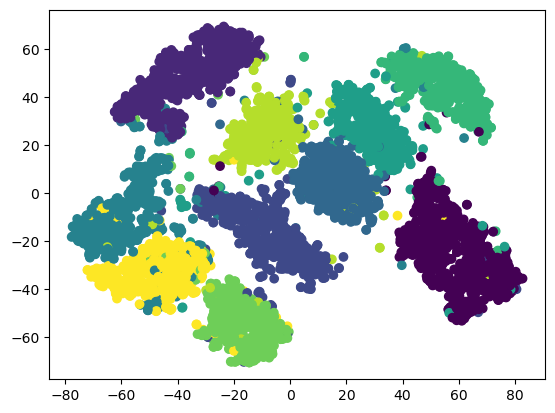

In [18]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_data = tsne.fit_transform(usps_train_x)

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=usps_train_y)
plt.show()

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


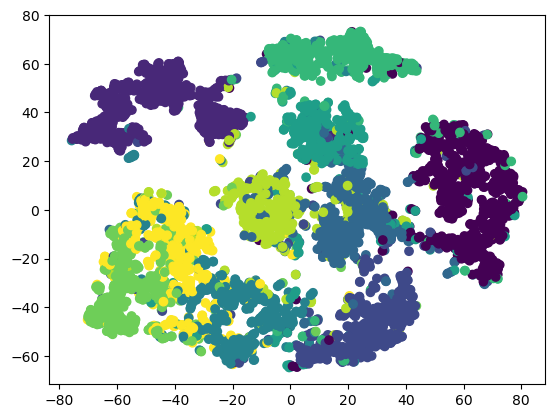

In [19]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_data = tsne.fit_transform(usps_train_latent_x)

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=usps_train_y)
plt.show()

In [20]:
def eval_fn(net, X_test, y_test):
    y_pred = net(X_test).argmax(1)
    y_test = y_test.argmax(1)
    return np.mean(y_pred == y_test)

In [21]:
net = Sequential(
    Linear(10, 100),
    TanH(),
    Linear(100, 100),
    TanH(),
    Linear(100, 10)
)

loss = CELoss()
epochs = 10_000
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    1e-1,
    usps_train_latent_x,
    usps_train_onehot_y,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    usps_val_latent_x,
    usps_val_onehot_y
)


Train : -----------------------------------
Epoch 1000: train loss: 0.3299613004744517 val loss: 0.32396514679224947 val eval_fn: 0.8944482522275531
Epoch 2000: train loss: 0.26489726810174063 val loss: 0.28379826378582523 val eval_fn: 0.9067854694996573
Epoch 3000: train loss: 0.2216619366351083 val loss: 0.2633322430829758 val eval_fn: 0.914324880054832
Epoch 4000: train loss: 0.18890682471574752 val loss: 0.25054154482021773 val eval_fn: 0.9204934886908842
Epoch 5000: train loss: 0.16239857244796985 val loss: 0.24198874896213735 val eval_fn: 0.9232350925291295
Epoch 6000: train loss: 0.14039426230636964 val loss: 0.23729794270828183 val eval_fn: 0.9266620973269363
Epoch 7000: train loss: 0.12191874003201177 val loss: 0.23582181649896097 val eval_fn: 0.9280328992460589
Epoch 8000: train loss: 0.10624861195403633 val loss: 0.23653100865789206 val eval_fn: 0.9287183002056203
Epoch 9000: train loss: 0.0928748602618165 val loss: 0.23866645896856065 val eval_fn: 0.9273474982864977
Epoch 1

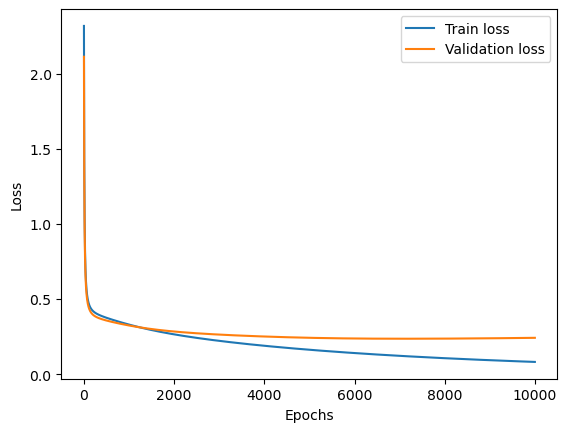

In [22]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

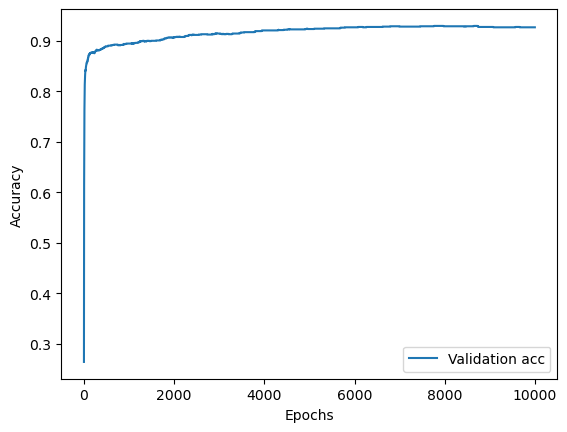

In [23]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
net.set_parameters(best_parameters)
print('Test acc :', eval_fn(net, usps_test_latent_x, usps_test_onehot_y))

Test acc : 0.8844045839561535


#### Linear(256,128) - TanH - Linear(128,64) - TanH - Linear(64,10) & Linear - Sigmoid - Linear - Sigmoid - Linear- Sigmoid - BCE

In [41]:
net = AutoEncoder(
    Sequential(
        Linear(256, 128),
        TanH(),
        Linear(128, 64),
        TanH(),
        Linear(64, 10),
        TanH(),
    ),
    Sequential(
        Linear(10, 64),
        Sigmoid(),
        Linear(64, 128),
        Sigmoid(),
        Linear(128, 256),
        Sigmoid(),
    )
)   
net.parameters_sharing()

In [42]:
lr = 1e-1
epochs = 2_000
loss = BCELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    usps_train_x,
    usps_train_x,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    None,
    usps_val_x,
    usps_val_x
)

Train : -----------------------------------
Epoch 200: train loss: 0.39111898422677754 val loss: 0.3865405887165597
Epoch 400: train loss: 0.36485783177275655 val loss: 0.3589663049004908
Epoch 600: train loss: 0.35290326835663777 val loss: 0.3461238021521812
Epoch 800: train loss: 0.34814507985086496 val loss: 0.34226993907869074
Epoch 1000: train loss: 0.3351927215012439 val loss: 0.3329227296102114
Epoch 1200: train loss: 0.3240243376290724 val loss: 0.3192252900568643
Epoch 1400: train loss: 0.31568507451198013 val loss: 0.3119239146511294
Epoch 1600: train loss: 0.3131283933258047 val loss: 0.3100379026100892
Epoch 1800: train loss: 0.3067929237082766 val loss: 0.3043461770808183
Epoch 2000: train loss: 0.30275744146507033 val loss: 0.30031942038313925
-------------------------------------------


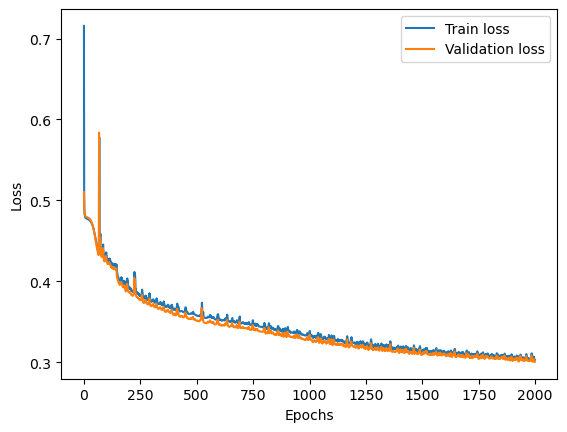

In [44]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
#net.set_parameters(best_parameters)
usps_train_autoencoder_x = net(usps_train_x)
usps_val_autoencoder_x = net(usps_val_x)
usps_test_autoencoder_x = net(usps_test_x)
usps_train_latent_x = net.get_encoder()(usps_train_x)
usps_val_latent_x = net.get_encoder()(usps_val_x)
usps_test_latent_x = net.get_encoder()(usps_test_x)

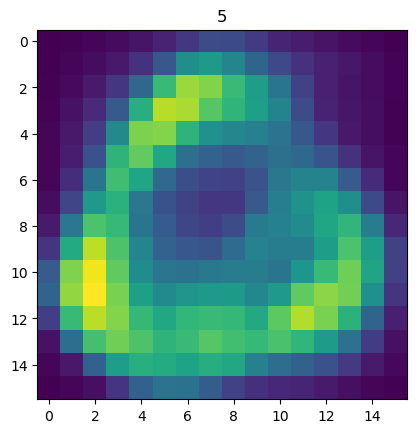

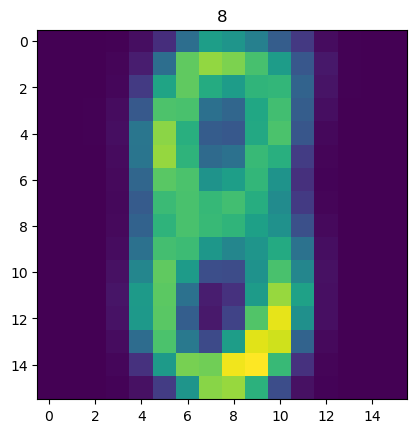

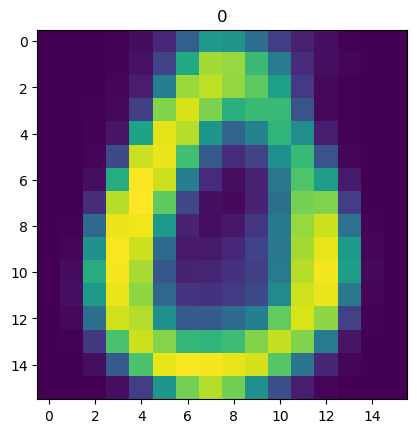

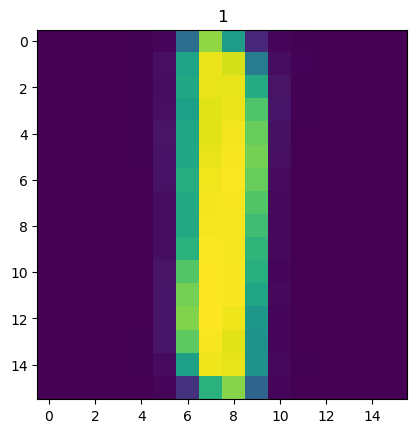

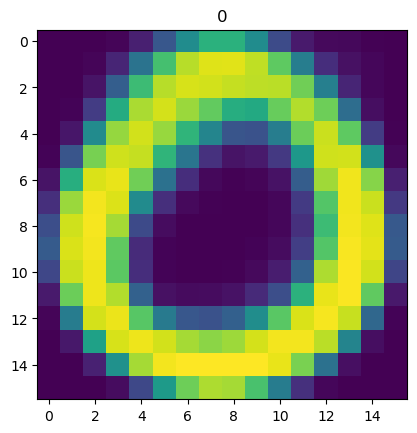

In [46]:
for i in np.random.randint(0, len(usps_train_y), 5):
    plt.figure()
    plt.title(str(usps_train_y[i]))
    show_usps(usps_train_autoencoder_x[i])
    plt.show()

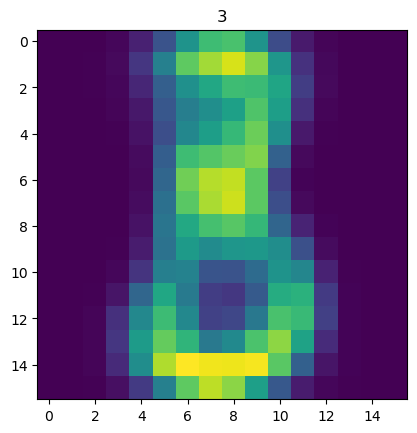

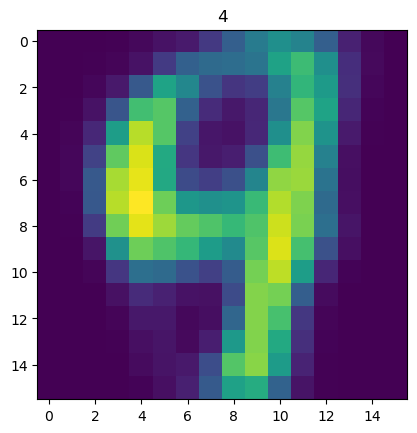

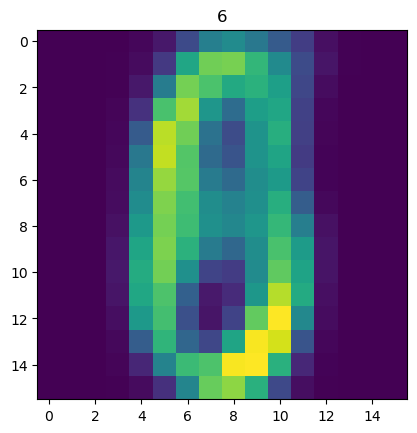

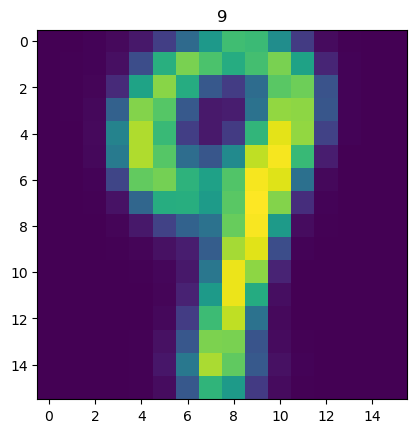

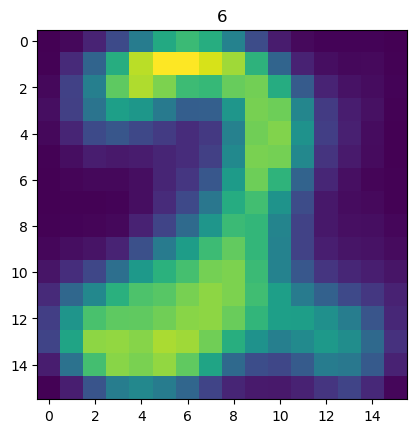

In [47]:
for i in np.random.randint(0, len(usps_test_y), 5):
    plt.figure()
    plt.title(str(usps_test_y[i]))
    show_usps(usps_test_autoencoder_x[i])
    plt.show()

In [48]:
kmeans = KMeans(n_clusters=10)
_ = kmeans.fit(usps_train_latent_x)

In [49]:
cluster_train_labels = kmeans.predict(usps_train_latent_x)
cluster_test_labels = kmeans.predict(usps_test_latent_x)

In [50]:
ari = adjusted_rand_score(usps_train_y, cluster_train_labels)
print(f'Train ARI = {ari}')
ari = adjusted_rand_score(usps_test_y, cluster_test_labels)
print(f'Test ARI = {ari}')

Train ARI = 0.4727457855133672
Test ARI = 0.4223961192863275


/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


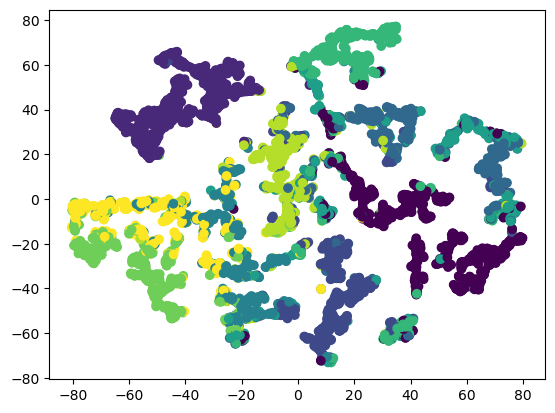

In [51]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_data = tsne.fit_transform(usps_train_latent_x)

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=usps_train_y)
plt.show()

In [55]:
net = Sequential(
    Linear(10, 10),
    TanH(),
    Linear(10, 10),
    TanH(),
    Linear(10, 10)
)

loss = CELoss()
epochs = 10_000
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    1e-1,
    usps_train_latent_x,
    usps_train_onehot_y,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    usps_val_latent_x,
    usps_val_onehot_y
)

Train : -----------------------------------
Epoch 1000: train loss: 0.5080924998506366 val loss: 0.5448370097117458 val eval_fn: 0.8368745716244003
Epoch 2000: train loss: 0.4638356661434338 val loss: 0.5135368925958737 val eval_fn: 0.8437285812200137
Epoch 3000: train loss: 0.4443841571390702 val loss: 0.5025199361315926 val eval_fn: 0.8450993831391364
Epoch 4000: train loss: 0.4336467343232164 val loss: 0.4987948138027502 val eval_fn: 0.8450993831391364
Epoch 5000: train loss: 0.42655092574097747 val loss: 0.49676882800017735 val eval_fn: 0.8423577793008911
Epoch 6000: train loss: 0.42119325420726433 val loss: 0.4948230323236448 val eval_fn: 0.8464701850582591
Epoch 7000: train loss: 0.4168545337763613 val loss: 0.493216774848699 val eval_fn: 0.8444139821795751
Epoch 8000: train loss: 0.4131664911159253 val loss: 0.49215967356146056 val eval_fn: 0.8450993831391364
Epoch 9000: train loss: 0.40988830422819833 val loss: 0.4916892855578958 val eval_fn: 0.8457847840986977
Epoch 10000: tra

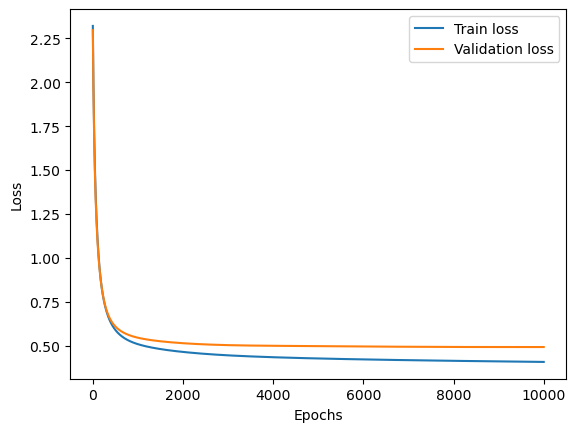

In [56]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

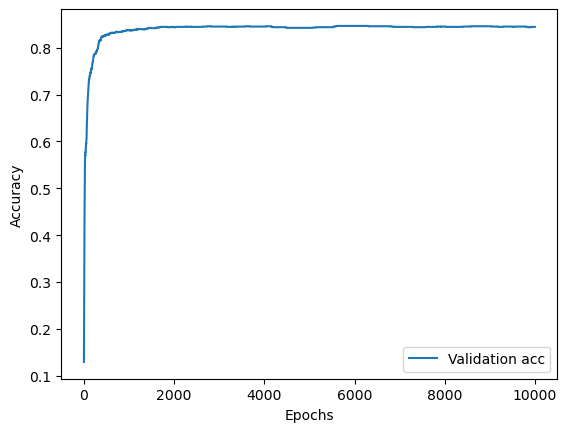

In [57]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [58]:
net.set_parameters(best_parameters)
print('Test acc :', eval_fn(net, usps_test_latent_x, usps_test_onehot_y))

Test acc : 0.8101644245142003


#### Linear(256,200) - Linear(200, 128) - TanH - Linear(128,100) - TanH - Linear(100, 64) - TanH- Linear(64,10) & Linear - Sigmoid - Linear - Sigmoid - Linear - Sigmoid - Linear - Sigmoid - Linear - Sigmoid + BCE

In [63]:
net = AutoEncoder(
    Sequential(
        Linear(256, 200),
        TanH(),
        Linear(200, 128),
        TanH(),
        Linear(128, 100),
        TanH(),
        Linear(100, 64),
        TanH(),
        Linear(64, 10), 
        TanH()
    ),
    Sequential(
        Linear(10, 64),
        Sigmoid(),
        Linear(64, 100),
        Sigmoid(),
        Linear(100, 128),
        Sigmoid(),
        Linear(128, 200),
        Sigmoid(),
        Linear(200, 256),
        Sigmoid()
    )
) 
net.parameters_sharing()

In [64]:
lr = 1e-4
epochs = 5_000
loss = MSELoss()
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    lr,
    usps_train_x,
    usps_train_x,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    None,
    usps_val_x,
    usps_val_x
)

Train : -----------------------------------
Epoch 500: train loss: 0.16892375920370972 val loss: 0.16945730957326
Epoch 1000: train loss: 0.1456992632982697 val loss: 0.14637681110030554
Epoch 1500: train loss: 0.13421582726525094 val loss: 0.13497918903988607
Epoch 2000: train loss: 0.12824194700195687 val loss: 0.1290594639380083
Epoch 2500: train loss: 0.12491133023668771 val loss: 0.12576653087944817
Epoch 3000: train loss: 0.1229282704881622 val loss: 0.12381194486263714
Epoch 3500: train loss: 0.12167608455723444 val loss: 0.12258252495926053
Epoch 4000: train loss: 0.1208434303357824 val loss: 0.1217687329915634
Epoch 4500: train loss: 0.12026423988680601 val loss: 0.12120551198378979
Epoch 5000: train loss: 0.11984541270719012 val loss: 0.12080038172054725
-------------------------------------------


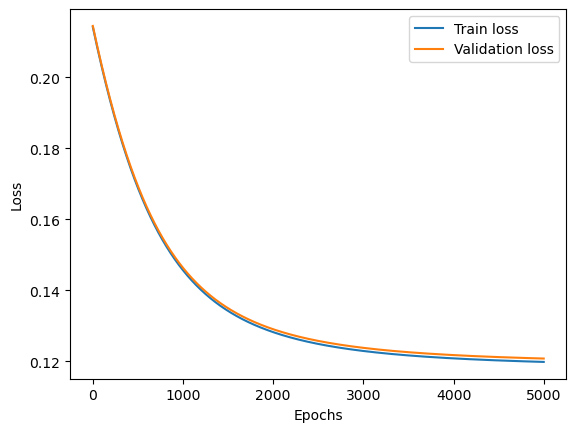

In [65]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
n#et.set_parameters(best_parameters)
usps_train_autoencoder_x = net(usps_train_x) 
usps_val_autoencoder_x = net(usps_val_x)
usps_test_autoencoder_x = net(usps_test_x)
usps_train_latent_x = net.get_encoder()(usps_train_x)
usps_val_latent_x = net.get_encoder()(usps_val_x)
usps_test_latent_x = net.get_encoder()(usps_test_x)

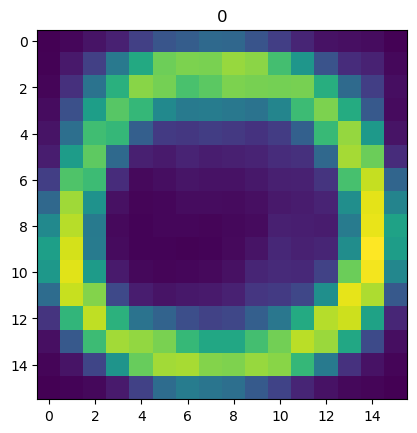

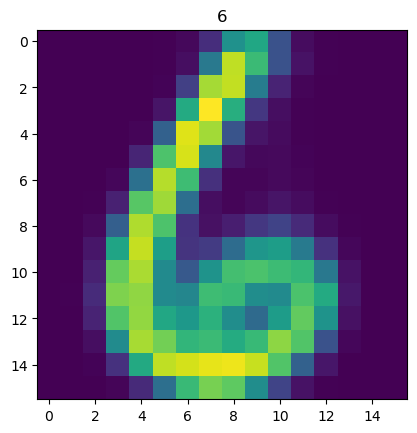

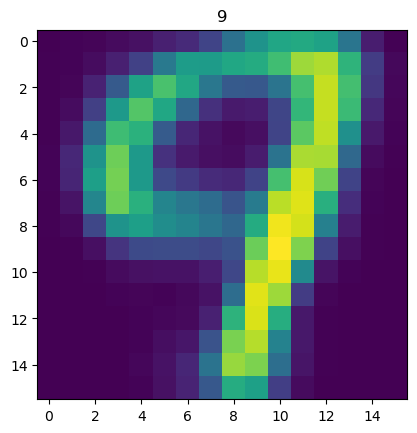

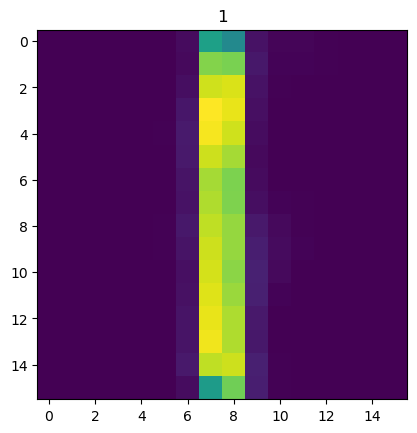

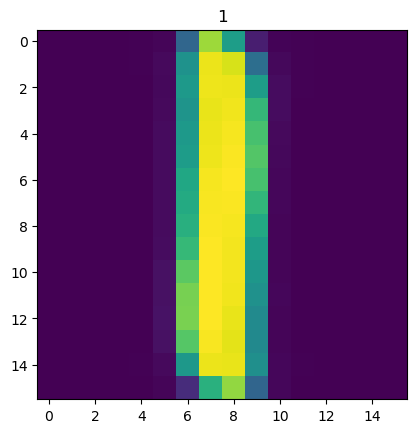

In [66]:
for i in np.random.randint(0, len(usps_train_y), 5):
    plt.figure()
    plt.title(str(usps_train_y[i]))
    show_usps(usps_train_autoencoder_x[i])
    plt.show()

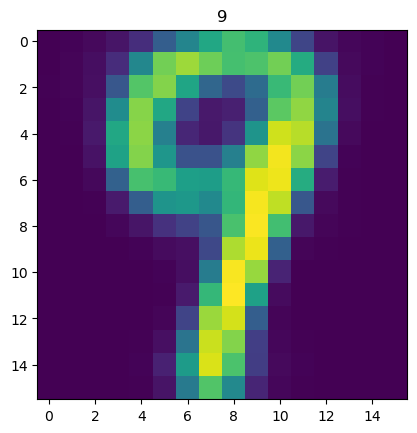

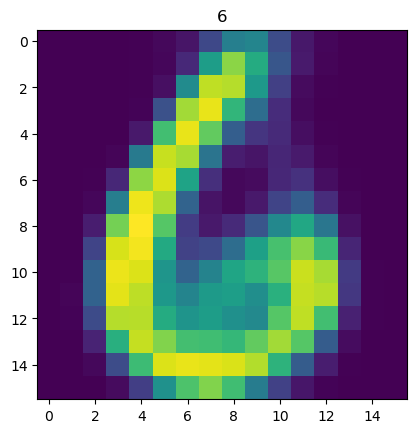

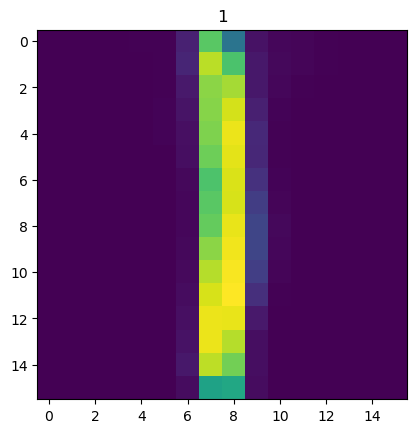

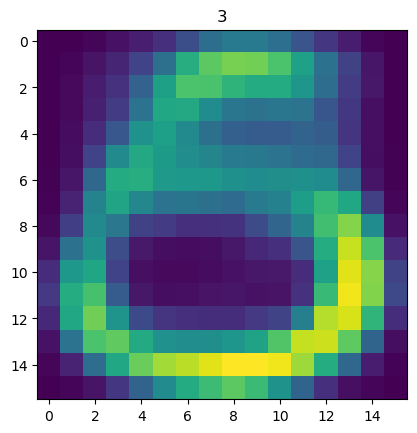

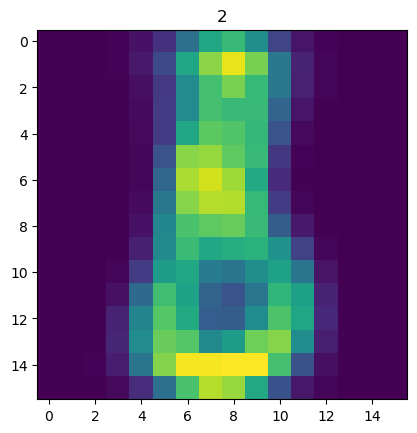

In [67]:
for i in np.random.randint(0, len(usps_test_y), 5):
    plt.figure()
    plt.title(str(usps_test_y[i]))
    show_usps(usps_test_autoencoder_x[i])
    plt.show()

In [68]:
kmeans = KMeans(n_clusters=10)
_ = kmeans.fit(usps_train_latent_x)

In [69]:
cluster_train_labels = kmeans.predict(usps_train_latent_x)
cluster_test_labels = kmeans.predict(usps_test_latent_x)

In [70]:
ari = adjusted_rand_score(usps_train_y, cluster_train_labels)
print(f'Train ARI = {ari}')
ari = adjusted_rand_score(usps_test_y, cluster_test_labels)
print(f'Test ARI = {ari}')

Train ARI = 0.5037027117189826
Test ARI = 0.45647350578184137


/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


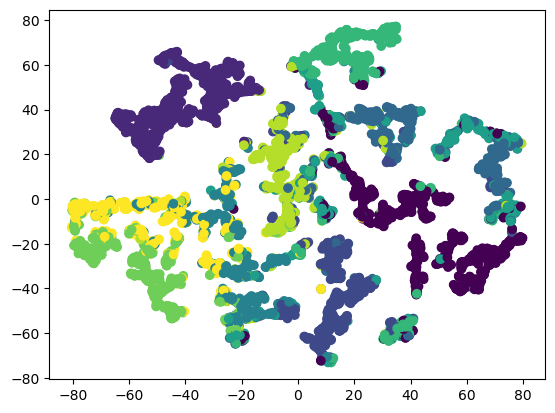

In [71]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_data = tsne.fit_transform(usps_train_latent_x)

plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=usps_train_y)
plt.show()

In [72]:
net = Sequential(
    Linear(10, 100),
    TanH(),
    Linear(100, 100),
    TanH(),
    Linear(100, 10)
)

loss = CELoss()
epochs = 10_000
all_loss, all_loss_valid, all_acc_valid, best_parameters = SGD(
    net,
    loss,
    1e-1,
    usps_train_latent_x,
    usps_train_onehot_y,
    epochs,
    GradientDescentMode.BATCH,
    -1,
    eval_fn,
    usps_val_latent_x,
    usps_val_onehot_y
)

Train : -----------------------------------
Epoch 1000: train loss: 0.4258306798784436 val loss: 0.4702824258150458 val eval_fn: 0.8450993831391364
Epoch 2000: train loss: 0.3933766976851588 val loss: 0.4556996972156977 val eval_fn: 0.8464701850582591
Epoch 3000: train loss: 0.3746861900945508 val loss: 0.45189720174891773 val eval_fn: 0.8464701850582591
Epoch 4000: train loss: 0.3604886318514269 val loss: 0.45118549010468556 val eval_fn: 0.8485263879369431
Epoch 5000: train loss: 0.34858586896444516 val loss: 0.4521603438721141 val eval_fn: 0.8498971898560658
Epoch 6000: train loss: 0.3379813400166279 val loss: 0.45416522984340424 val eval_fn: 0.8505825908156271
Epoch 7000: train loss: 0.3281420619948398 val loss: 0.45684787045971775 val eval_fn: 0.8526387936943112
Epoch 8000: train loss: 0.31883009899981085 val loss: 0.4599942036649334 val eval_fn: 0.8540095956134338
Epoch 9000: train loss: 0.30993450165766756 val loss: 0.46354614905391245 val eval_fn: 0.8533241946538725
Epoch 10000:

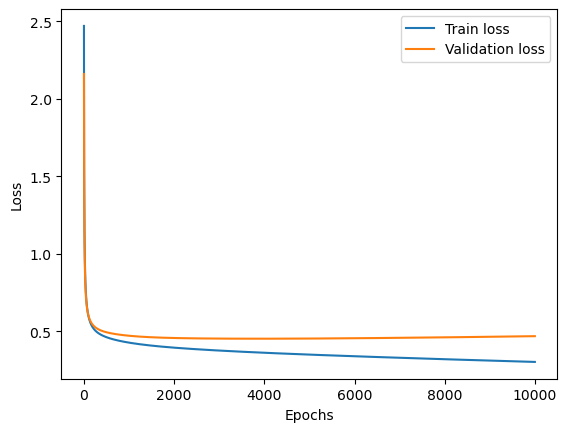

In [73]:
plt.plot(all_loss, label='Train loss')
plt.plot(all_loss_valid, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

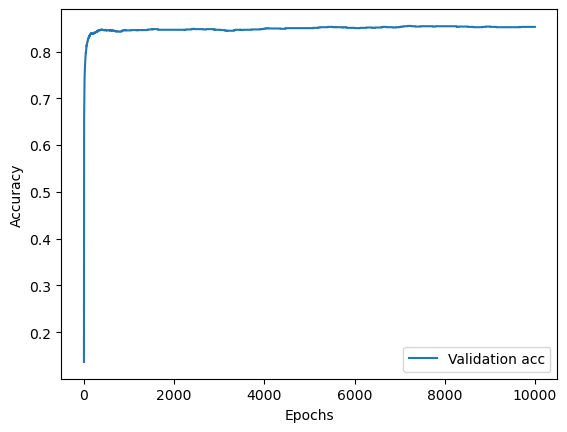

In [74]:
plt.plot(all_acc_valid, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [75]:
net.set_parameters(best_parameters)
print('Test acc :', eval_fn(net, usps_test_latent_x, usps_test_onehot_y))

Test acc : 0.8221225710014948
